# Independent Component Analysis

### True Sources Signals

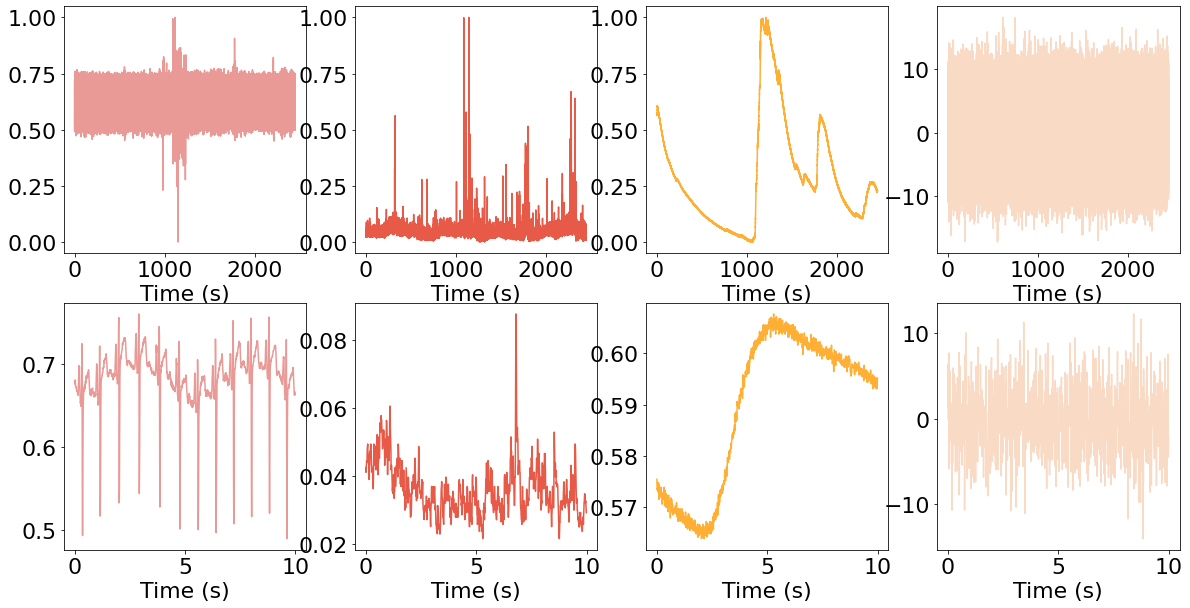

In [17]:
#@title
import matplotlib
import matplotlib.pyplot as plt
from sklearn.datasets import load_linnerud
from sklearn.decomposition import FastICA
from sklearn.preprocessing import MinMaxScaler
import pandas as pd
import numpy as np
import os
import seaborn as sns
import urllib.request

matplotlib.rcParams.update({'font.size': 22})

colors = ["#EA9A96", "#E75A48", "#FFB034", "#F8DAC5"]

urllib.request.urlretrieve('https://raw.githubusercontent.com/mfmachado/adar/main/notebooks/data.csv', 'data.csv')

df_raw = pd.read_csv('data.csv')
times = df_raw["daqtime"].values/1000

noise = np.random.normal(0, 1, df_raw.shape[0])*4

df_signals = pd.DataFrame(MinMaxScaler().fit_transform(df_raw[["ecg", "emg_zygo","gsr"]]), columns=["ecg", "emg_zygo","gsr"])
df_signals["noise"] = noise

f, ax = plt.subplots(2, df_signals.shape[1], figsize=(20, 10))
for i, component in enumerate(df_signals.values.T):
    ax[0, i].plot(times, component, color=colors[i])
    ax[1, i].plot(times[:1000], component[:1000], color=colors[i])
    ax[0, i].set_xlabel("Time (s)")
    ax[1, i].set_xlabel("Time (s)")

### Create a mixture of the signals with gaussian noise

In [18]:
# Mixture Matrix, the last column is the gaussian noise 
mixing_matrix = np.asarray([[0.002, 0.1, 0.01, 0.9], 
                            [0.005, 0.95, -0.1, 0.8], 
                            [0.001, 0.1, 0.001, 0.7], 
                            [0.05, 0.1, 0.2, 0.6]])

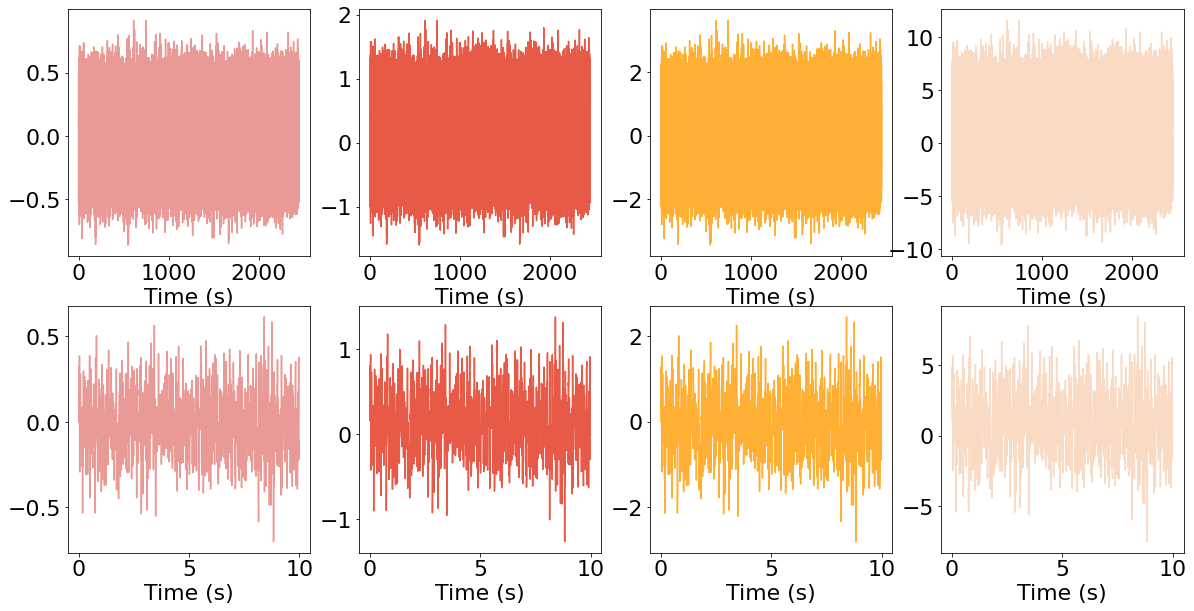

In [19]:
#@title

data = np.matmul(df_signals.values, mixing_matrix)

f, ax = plt.subplots(2, data.shape[1], figsize=(20, 10))
for i, component in enumerate(data.T):
    ax[0, i].plot(times, component, color=colors[i])
    ax[1, i].plot(times[:1000], component[:1000], color=colors[i])
    ax[0, i].set_xlabel("Time (s)")
    ax[1, i].set_xlabel("Time (s)")

#### Mixture of the signals without the gaussian noise

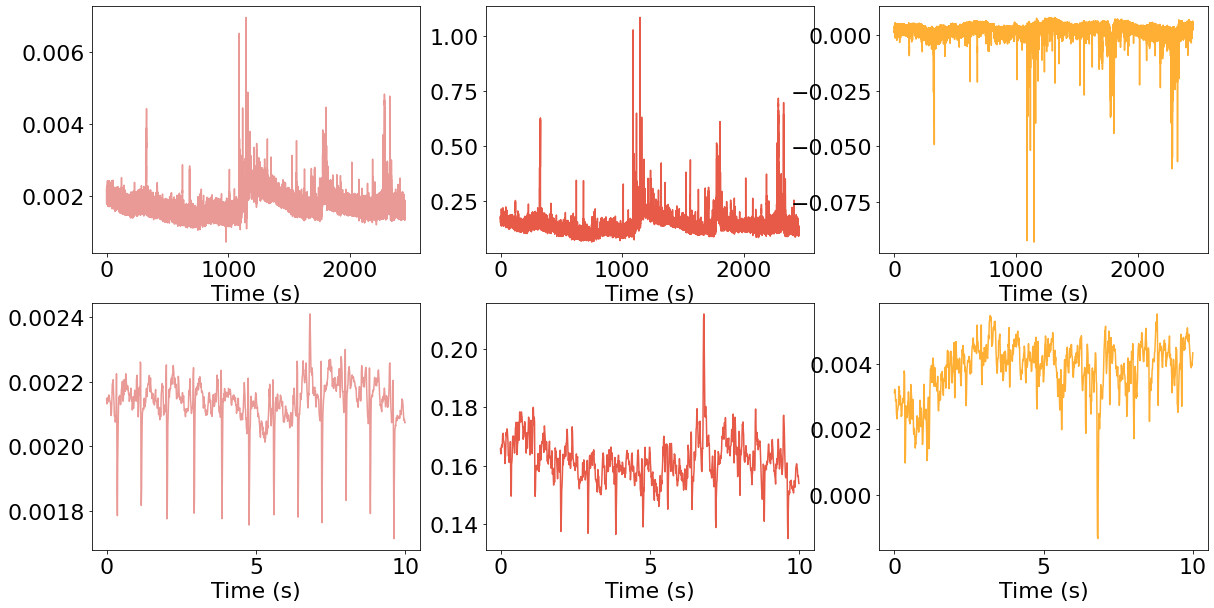

In [20]:
#@title

# Build the mixture without the noise component
data = np.matmul(df_signals.values[:, :-1], mixing_matrix[:-1, :-1])

f, ax = plt.subplots(2, data.shape[1], figsize=(20, 10))
for i, component in enumerate(data.T):
    ax[0, i].plot(times, component, color=colors[i])
    ax[1, i].plot(times[:1000], component[:1000], color=colors[i])
    ax[0, i].set_xlabel("Time (s)")
    ax[1, i].set_xlabel("Time (s)")

## FastICA to the mixture with noise

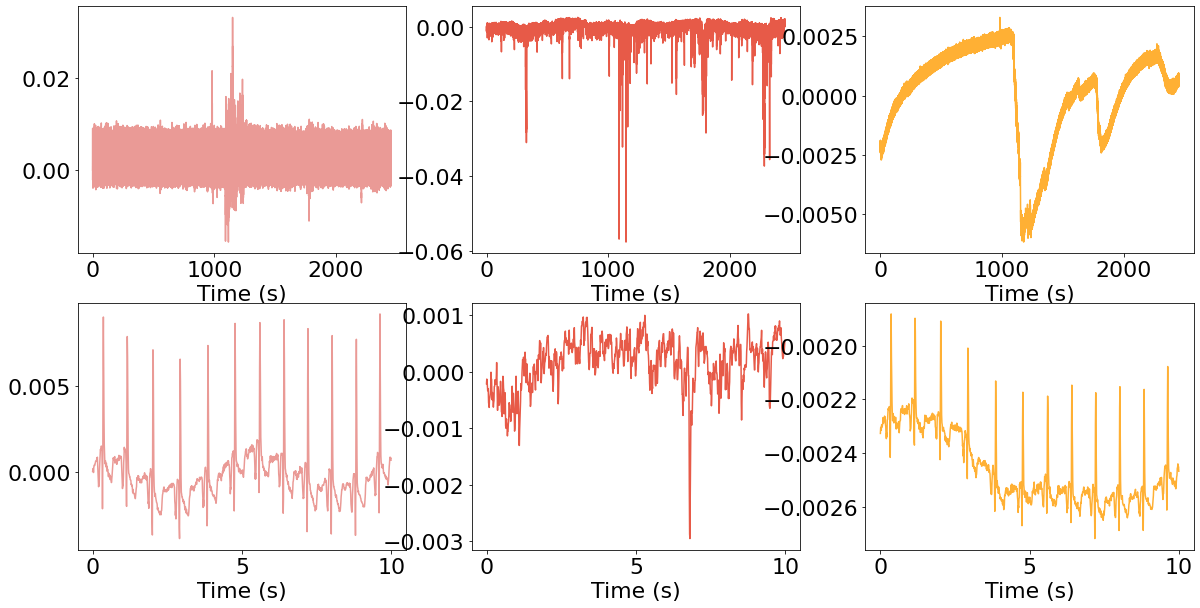

In [21]:
#@title

transformer = FastICA(n_components=data.shape[-1], random_state=0)
X_transformed = transformer.fit_transform(data)
X_transformed.shape

f, ax = plt.subplots(2, X_transformed.shape[1], figsize=(20, 10))
for i, component in enumerate(X_transformed.T):
    ax[0, i].plot(times, component, color=colors[i])
    ax[1, i].plot(times[:1000], component[:1000], color=colors[i])
    ax[0, i].set_xlabel("Time (s)")
    ax[1, i].set_xlabel("Time (s)")

## Reconstruct components

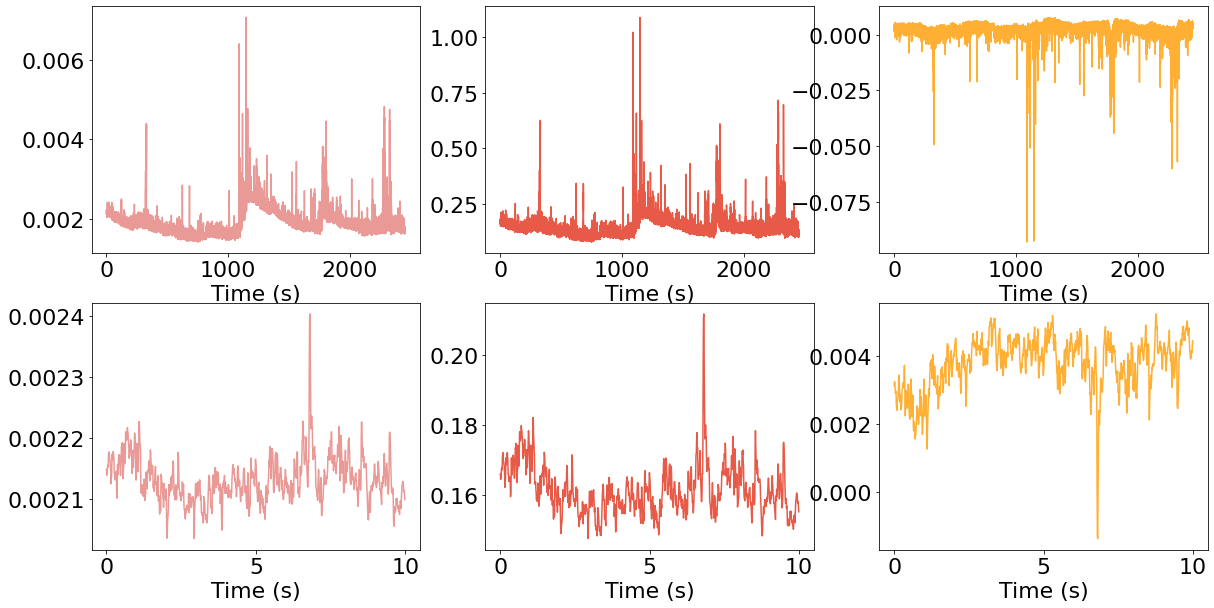

In [22]:
#@title
## Remove bad components
components_rejected = [0]

for i in components_rejected:
    X_transformed[:, i] = 0

## Reconstrctured Signals
X_restored = transformer.inverse_transform(X_transformed)

f, ax = plt.subplots(2, X_restored.shape[1], figsize=(20, 10))
for i, component in enumerate(X_restored.T):
    ax[0, i].plot(times, component, color=colors[i])
    ax[1, i].plot(times[:1000], component[:1000], color=colors[i])
    ax[0, i].set_xlabel("Time (s)")
    ax[1, i].set_xlabel("Time (s)")